## CNN creation
The goal of this Notebook is to create a Convolutional Neural Network (CNN) to classify the 3D images of the brain as cognitively normal (CN) or Alzheimer (AD).

This notebook is structured as follows:
   - Initial setup
   - Import libraries
   - Load TFRecords
   - Preprocessing
   - Define and train Convolutional Neural Network
   - Model evaluation

### Initial set-up

#### Google Drive

In [1]:
# Specify if user is working on Google Drive
google_drive = True

In [2]:
if google_drive == True:

    # Authentication Google Drive for desktop
    from google.colab import drive 
    drive.mount('/content/drive')
    
    path = './drive/MyDrive/TFM/Code/'
    
    import sys
    sys.path.append(path)

else:
    path = '../'
    
    import sys
    sys.path.append(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Google Colab TPU session

In [3]:
# Specify if user is working on a TPU session in Google Colab
tpu_session = True

In [4]:
if tpu_session == True:
    
    %tensorflow_version 2.x
    import tensorflow as tf
    print('Tensorflow version ' + tf.__version__)

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
else:
    pass

Tensorflow version 2.5.0
Running on TPU  ['10.78.231.194:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.78.231.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.231.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Import libraries

In [7]:
import time
import numpy as np
from functools import reduce
from sklearn.model_selection import KFold 

# Import tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, BatchNormalization, GlobalAveragePooling3D, GlobalMaxPooling3D, Dense, Dropout
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta, Adagrad
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Extra utils
from Notebooks.aux_functions.aux_functions_cnn import *

### Load TFRecords

In [5]:
# Specify Google Cloud Storage bucket path where the TFRecords have been saved
gcs_path = 'gs://tfm-kschool-bucket/TFRecords/'

In [6]:
# Authentication Google Cloud SDK
from google.colab import auth
auth.authenticate_user()

In [ ]:
#gcs_path = path + 'Datasets/TFRecords/'

#### Load train TFRecords

In [40]:
train_dataset = load_tfr_dataset(tfr_dir = gcs_path,
                                 pattern = 'Train/*_train_volumes.tfrecords')

#### Load validation TFRecords

In [41]:
val_dataset = load_tfr_dataset(tfr_dir = gcs_path,
                               pattern = 'Validation/*_val_volumes.tfrecords')

#### Load test TFRecords

In [42]:
test_dataset = load_tfr_dataset(tfr_dir = gcs_path,
                                pattern = 'Test/*_test_volumes.tfrecords')

#### Check size of training, validation and testing datasets

In [11]:
train_size = reduce(lambda count, item: count + 1, train_dataset, 0)
val_size = reduce(lambda count, item: count + 1, val_dataset, 0)
test_size = reduce(lambda count, item: count + 1, test_dataset, 0)

In [12]:
print(f'[+] Training size:', train_size)
print(f'[+] Validation size:', val_size)
print(f'[+] Testing size:', test_size)

[+] Training size: 759
[+] Validation size: 163
[+] Testing size: 163


#### Batch datasets

In [43]:
# Specify batch size
batch_size = 32

In [44]:
train_dataset = train_dataset.batch(batch_size).prefetch(1)
val_dataset = val_dataset.batch(batch_size).prefetch(1)
test_dataset = test_dataset.batch(batch_size).prefetch(1)

### Convolutional Neural Network

#### Define Neural Network

In [45]:
def build_model_3d(model_name, input_shape):
    '''
    Build a 3D Convolutional Neural Network (CNN).
    '''

    # Fix random seed for reproducibility
    np.random.seed(123)
    tf.random.set_seed(123) 
    
    ## Input layer
    inputs = Input(shape = input_shape + (1,))
    
    ## Convolutional blocks
    # 1st conv block
    x = Conv3D(64, kernel_size = 3, activation = 'relu')(inputs)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)
              
    # 2nd conv block
    x = Conv3D(128, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)

    # 3rd conv block
    x = Conv3D(256, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)

    # 4rd conv block
    x = Conv3D(512, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)
    
    ## Flatten layer
    x = GlobalAveragePooling3D()(x)
              
    ## Dense layers       
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.3)(x)

    ## Output layer
    outputs = Dense(1, activation = 'sigmoid')(x)

    # Define the model
    model = Model(inputs, outputs)
    
    # Name model
    model._name = model_name
    
    return model

#### Build new CNN model

In [46]:
# Define inputs
model_name = 'cnn_model_v3'
input_shape = (110, 130, 80)

In [47]:
# Define optimizer
optimizer = Adam(learning_rate = 0.0001, decay = 1e-6)

In [48]:
# TPU strategy
with tpu_strategy.scope(): 
    
    # Build mode
    model = build_model_3d(model_name, input_shape)

    # Compile model
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = [BinaryAccuracy(), f1])

#model.summary()

#### Setup callbacks

**EarlyStopping** in this case tracks the val_loss value, stops the training if there are no changes towards val_loss after 3 epochs, and keeps the best weights once the training stops.

In [19]:
callback_early_stopping = EarlyStopping(monitor = 'val_loss',
                                        min_delta = 0,
                                        patience = 5,
                                        verbose = 1,
                                        restore_best_weights = True)

**ModelCheckpoint** saves the best model in the folder Results. It tracks the metric val_loss and saves the model after each epoch only if val_loss has been reduced in compared to the previous model saved.

In [20]:
callback_checkpoint = ModelCheckpoint(path + 'Results/' + model.name + '.h5',
                                      monitor = 'val_loss',
                                      mode = 'min',
                                      save_best_only = True,
                                      verbose = 1)

#### Train CNN model

In [49]:
# Train model
start_time = time.time()

history = model.fit(train_dataset,
                    epochs = 100,
                    validation_data = val_dataset,
                    verbose = 1)

end_time = time.time()
print('\n[+] Time of training: '+'{:.2f}'.format(end_time-start_time));

Epoch 1/100
24/24 [==============================] - 75s 2s/step - loss: 0.6679 - binary_accuracy: 0.6179 - f1: 0.5734 - val_loss: 0.6981 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 26s 696ms/step - loss: 0.6319 - binary_accuracy: 0.6561 - f1: 0.6038 - val_loss: 0.7162 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 3/100
24/24 [==============================] - 27s 686ms/step - loss: 0.6153 - binary_accuracy: 0.6759 - f1: 0.6353 - val_loss: 0.7575 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 4/100
24/24 [==============================] - 24s 597ms/step - loss: 0.5969 - binary_accuracy: 0.6838 - f1: 0.6342 - val_loss: 0.7842 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 5/100
24/24 [==============================] - 23s 642ms/step - loss: 0.5776 - binary_accuracy: 0.7036 - f1: 0.6520 - val_loss: 0.7254 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 6/100
24/24 [========================

#### Load existing CNN model
Run the following cells only if you want to analyze an existing model.

In [8]:
model_name = 'cnn_model_v2'

In [14]:
# Load model
model = load_model(path + 'Results/' + model_name + '.h5', 
                   custom_objects = {'f1': f1})

print('[+] Model loaded')
#model.summary()

[+] Model loaded


In [9]:
# Load model history
history = np.load(path + 'Results/' + model_name + '_history.npy', 
                  allow_pickle = 'TRUE').item()

print('[+] Model history loaded')

[+] Model history loaded


### Evaluation 

#### Metrics

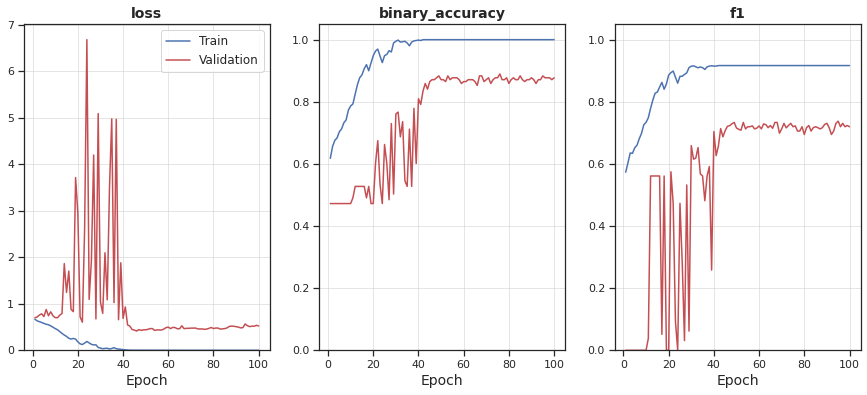

In [10]:
# Plot metrics
plot_history(history, 
             save_fig = path + 'Results/figures/model_history.png')

In [ ]:
# Get accuracy
model.evaluate(train_dataset,
               verbose = 0)

#### Evaluation training dataset

In [20]:
# Get training true labels
train_true_labels = get_true_labels(train_dataset)

In [14]:
# Get training predicted labels
train_predicted_labels = get_predicted_labels(model, train_dataset)

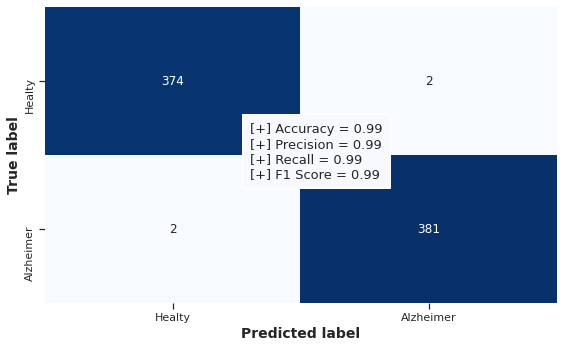

In [15]:
# Get evaluation 
get_evaluation(train_true_labels, train_predicted_labels, 
               save_fig = path + 'Results/figures/train_cm.png')

#### Evaluation testing dataset

In [15]:
# Get testing true labels
test_true_labels = get_true_labels(test_dataset)

In [16]:
# Get testing predicted labels
test_predicted_labels = get_predicted_labels(model, test_dataset)

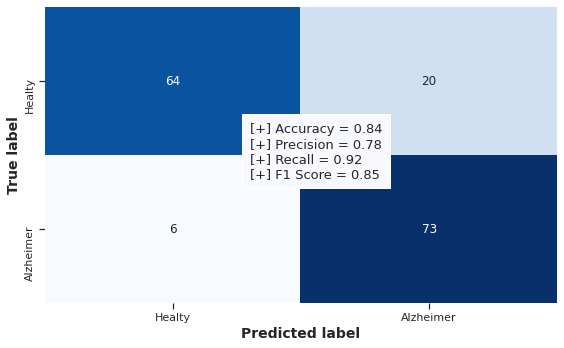

In [17]:
# Get evaluation 
get_evaluation(test_true_labels, test_predicted_labels,
               save_fig = path + 'Results/figures/test_cm.png')

#### Roc curve

[+] Train AUC score = 1.000
[+] Test AUC score = 0.942


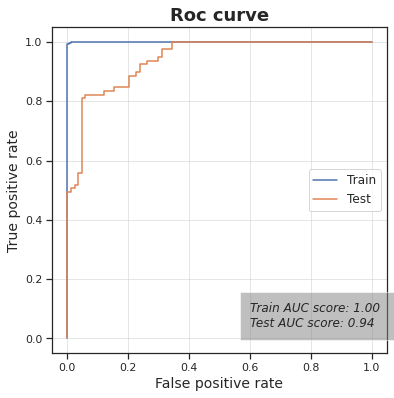

In [25]:
plot_roc_curve(model, 
               train_dataset, test_dataset, train_true_labels, test_true_labels, 
               save_fig = path + 'Results/figures/roc_curve.png')

#### Save CNN model

In [50]:
# Save CNN model
#model.save(path + 'Results/' + model.name + '.h5')

print('[+] Model saved')

# Save CNN model history
np.save(path + 'Results/' + model.name + '_history.npy', history.history)

print('[+] Model history saved')

[+] Model saved
[+] Model history saved


### Optuna study

#### Import Optuna

In [ ]:
pip install optuna

In [29]:
import optuna 

#### Optuna preprocessing

In [ ]:
# Get testing true labels
val_true_labels = get_true_labels(val_dataset)

In [ ]:
# Define callback
callback_early_stopping = EarlyStopping(monitor = 'val_loss',
                                        min_delta = 0,
                                        patience = 5,
                                        verbose = 1,
                                        restore_best_weights = True)

#### Define functions

In [ ]:
def build_model_optuna(input_shape, flatten_layer):
    '''
    Build a 3D Convolutional Neural Network (CNN).
    '''

    # Fix random seed for reproducibility
    np.random.seed(123)
    tf.random.set_seed(123) 
    
    ## Input layer
    inputs = Input(shape = input_shape + (1,))
    
    ## Convolutional blocks
    # 1st conv block
    x = Conv3D(64, kernel_size = 3, activation = 'relu')(inputs)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)
              
    # 2nd conv block
    x = Conv3D(128, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)

    # 3rd conv block
    x = Conv3D(256, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)

    # 4rd conv block
    x = Conv3D(512, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)
    
    ## Flatten layer
    if flatten_layer == 'GlobalAveragePooling3D':
        x = GlobalAveragePooling3D()(x)

    elif flatten_layer == 'GlobalMaxPooling3D':
        x = GlobalMaxPooling3D()(x)

    ## Dense layers       
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.3)(x)

    ## Output layer
    outputs = Dense(1, activation = 'sigmoid')(x)

    # Define the model
    global model
    model = Model(inputs, outputs)
    
    return model

In [ ]:
def get_optimizer(optimizer_name, learning_rate):

    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate = learning_rate, 
                        decay = 1e-6)
        
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate = learning_rate, 
                             decay = 1e-6)

    elif optimizer_name == 'Adadelta':
        optimizer = Adadelta(learning_rate = learning_rate, 
                             decay = 1e-6)

    elif optimizer_name == 'Adagrad':
        optimizer = Adagrad(learning_rate = learning_rate, 
                             decay = 1e-6)
    
    return optimizer

In [ ]:
# Objective function
def objective(trial, train_dataset, val_dataset, val_true_labels, study_name):
    
    # Define optuna optimization parameters  
    learning_rate = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])  
    optimizer_name = trial.suggest_categorical('optimizer',['Adam', 'RMSprop', 
                                                            'Adadelta', 'Adagrad'])
    flatten_layer = trial.suggest_categorical('flatten_layer',['GlobalAveragePooling3D',
                                                               'GlobalMaxPooling3D'])

    # Define inputs
    model_name = '3d_model_optuna'
    input_shape = (110, 130, 80)

    # Get optimizer
    optimizer = get_optimizer(optimizer_name, learning_rate)

    # TPU strategy
    with tpu_strategy.scope(): 

        # Build model
        model = build_model_optuna(input_shape, flatten_layer)

        # Compile model
        model.compile(loss = 'binary_crossentropy',
                      optimizer = optimizer,
                      metrics = [BinaryAccuracy(), f1]) 
    # Train model
    history = model.fit(train_dataset,
                        epochs = 60,
                        validation_data = val_dataset,
                        verbose = 1)
  
    # Save CNN model history
    np.save(study_name + '_history_trial_' + str(trial.number) + '.npy', 
            history.history)
        
    # Get validation predicted labels
    val_predicted_labels = get_predicted_labels(model, val_dataset)
      
    # Evaluate the model (F1 score) with the validation dataset
    f1_score_metric = f1_score(val_true_labels, val_predicted_labels, average = 'weighted')

    return f1_score_metric

#### Run Optuna analysis

In [ ]:
# Define Optuna study name
study_name = path + 'Results/optuna_studies/study_v1'

# Specify number of iterations
n_trials = 5

# Create Optuna study
study = optuna.create_study(study_name = study_name, 
                            direction = 'maximize', 
                            load_if_exists = True,  
                            storage = f'sqlite:///{study_name}.db')
    
study.optimize(lambda trial: objective(trial, train_dataset, val_dataset, val_true_labels, study_name), 
               n_trials = n_trials)

[I 2021-06-25 13:36:42,019] Using an existing study with name './drive/MyDrive/TFM/Code/Results/optuna_studies/study_v1' instead of creating a new one.


Epoch 1/60
24/24 [==============================] - 61s 1s/step - loss: 39.5027 - binary_accuracy: 0.5020 - f1: 0.4161 - val_loss: 17.6665 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 2/60
24/24 [==============================] - 20s 509ms/step - loss: 0.7462 - binary_accuracy: 0.5204 - f1: 0.4029 - val_loss: 1.4727 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 3/60
24/24 [==============================] - 18s 451ms/step - loss: 0.7388 - binary_accuracy: 0.4967 - f1: 0.3761 - val_loss: 1.2829 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 4/60
24/24 [==============================] - 20s 506ms/step - loss: 0.7966 - binary_accuracy: 0.4954 - f1: 0.3889 - val_loss: 0.7338 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 5/60
24/24 [==============================] - 21s 573ms/step - loss: 0.7987 - binary_accuracy: 0.5046 - f1: 0.4124 - val_loss: 0.7192 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 6/60
24/24 [============================

[I 2021-06-25 13:59:19,078] Trial 9 finished with value: 0.7445126107702795 and parameters: {'learning_rate': 0.01, 'optimizer': 'RMSprop', 'flatten_layer': 'GlobalMaxPooling3D'}. Best is trial 0 with value: 0.8528716759671175.


Epoch 1/60
24/24 [==============================] - 61s 1s/step - loss: 1.7791 - binary_accuracy: 0.5231 - f1: 0.4034 - val_loss: 0.9480 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 2/60
24/24 [==============================] - 23s 581ms/step - loss: 0.7853 - binary_accuracy: 0.4848 - f1: 0.3918 - val_loss: 0.7794 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 3/60
24/24 [==============================] - 21s 530ms/step - loss: 0.7702 - binary_accuracy: 0.4769 - f1: 0.3875 - val_loss: 0.6951 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 4/60
24/24 [==============================] - 22s 589ms/step - loss: 0.7533 - binary_accuracy: 0.5059 - f1: 0.4386 - val_loss: 0.6930 - val_binary_accuracy: 0.5276 - val_f1: 0.5612
Epoch 5/60
24/24 [==============================] - 31s 829ms/step - loss: 0.7417 - binary_accuracy: 0.5217 - f1: 0.4579 - val_loss: 0.7372 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 6/60
24/24 [==============================] - 

[I 2021-06-25 14:22:34,595] Trial 10 finished with value: 0.8488394155967365 and parameters: {'learning_rate': 0.001, 'optimizer': 'RMSprop', 'flatten_layer': 'GlobalMaxPooling3D'}. Best is trial 0 with value: 0.8528716759671175.


Epoch 1/60
24/24 [==============================] - 67s 1s/step - loss: 0.6721 - binary_accuracy: 0.5955 - f1: 0.5613 - val_loss: 0.7235 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 2/60
24/24 [==============================] - 23s 565ms/step - loss: 0.6333 - binary_accuracy: 0.6509 - f1: 0.5881 - val_loss: 0.7753 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 3/60
24/24 [==============================] - 21s 579ms/step - loss: 0.6121 - binary_accuracy: 0.6851 - f1: 0.6307 - val_loss: 0.8031 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 4/60
24/24 [==============================] - 20s 518ms/step - loss: 0.5963 - binary_accuracy: 0.6693 - f1: 0.6126 - val_loss: 0.8171 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 5/60
24/24 [==============================] - 20s 479ms/step - loss: 0.5775 - binary_accuracy: 0.6970 - f1: 0.6414 - val_loss: 0.8366 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 6/60
24/24 [==============================

[I 2021-06-25 14:43:18,937] Trial 11 finished with value: 0.8956661189719101 and parameters: {'learning_rate': 0.0001, 'optimizer': 'Adam', 'flatten_layer': 'GlobalAveragePooling3D'}. Best is trial 11 with value: 0.8956661189719101.


Epoch 1/60
24/24 [==============================] - 60s 1s/step - loss: 0.6646 - binary_accuracy: 0.6285 - f1: 0.5735 - val_loss: 0.7025 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 2/60
24/24 [==============================] - 20s 497ms/step - loss: 0.6389 - binary_accuracy: 0.6535 - f1: 0.6018 - val_loss: 0.7111 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 3/60
24/24 [==============================] - 17s 455ms/step - loss: 0.6072 - binary_accuracy: 0.6601 - f1: 0.6163 - val_loss: 0.7166 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 4/60
24/24 [==============================] - 18s 492ms/step - loss: 0.5974 - binary_accuracy: 0.6653 - f1: 0.6169 - val_loss: 0.7765 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 5/60
24/24 [==============================] - 17s 448ms/step - loss: 0.5728 - binary_accuracy: 0.6917 - f1: 0.6457 - val_loss: 0.7657 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 6/60
24/24 [==============================

[I 2021-06-25 15:04:44,054] Trial 12 finished with value: 0.8516932964785726 and parameters: {'learning_rate': 0.0001, 'optimizer': 'Adam', 'flatten_layer': 'GlobalAveragePooling3D'}. Best is trial 11 with value: 0.8956661189719101.


Epoch 1/60
24/24 [==============================] - 70s 2s/step - loss: 0.6778 - binary_accuracy: 0.6034 - f1: 0.5249 - val_loss: 0.6994 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 2/60
24/24 [==============================] - 23s 585ms/step - loss: 0.6327 - binary_accuracy: 0.6509 - f1: 0.5877 - val_loss: 0.6917 - val_binary_accuracy: 0.5399 - val_f1: 0.4149
Epoch 3/60
24/24 [==============================] - 22s 630ms/step - loss: 0.6104 - binary_accuracy: 0.6706 - f1: 0.6142 - val_loss: 0.7152 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 4/60
24/24 [==============================] - 21s 529ms/step - loss: 0.5808 - binary_accuracy: 0.6943 - f1: 0.6363 - val_loss: 0.8111 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 5/60
24/24 [==============================] - 18s 454ms/step - loss: 0.5730 - binary_accuracy: 0.7049 - f1: 0.6444 - val_loss: 0.8314 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00
Epoch 6/60
24/24 [==============================] - 

[I 2021-06-25 15:24:52,039] Trial 13 finished with value: 0.8711169704947125 and parameters: {'learning_rate': 0.0001, 'optimizer': 'Adam', 'flatten_layer': 'GlobalAveragePooling3D'}. Best is trial 11 with value: 0.8956661189719101.


In [ ]:
# Check besr hyperparameters setup
print('- Best F1 score: {}'.format(study.best_trial.value))
print('- Best hyperparameters: {}'.format(study.best_trial.params))

- Best F1 score: 0.8956661189719101
- Best hyperparameters: {'flatten_layer': 'GlobalAveragePooling3D', 'learning_rate': 0.0001, 'optimizer': 'Adam'}


#### Load existing Optuna study

In [30]:
study_name = path + 'Results/optuna_studies/study_v1'
storage_name = 'sqlite:///{}.db'.format(study_name)

study = optuna.load_study(study_name = study_name, 
                          storage = storage_name)

#### Visualize Optuna study results

In [ ]:
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!apt-get install poppler-utils 

In [34]:
fig = optuna.visualization.plot_param_importances(study = study)
fig.write_image(path + 'Results/figures/optuna_fig1.eps')
fig.show()

In [35]:
fig = optuna.visualization.plot_parallel_coordinate(study = study)
fig.write_image(path + 'Results/figures/optuna_fig2.eps')
fig.show()

In [36]:
fig = optuna.visualization.plot_slice(study = study)
fig.write_image(path + 'Results/figures/optuna_fig3.eps')
fig.show()

In [37]:
fig = optuna.visualization.plot_optimization_history(study = study)
fig.write_image(path + 'Results/figures/optuna_fig4.eps')
fig.show()

### Cross-validation

#### Get TFRecords files paths

In [108]:
files = tf.io.gfile.glob(gcs_path + 'Train/*_train_volumes.tfrecords')
files = files + tf.io.gfile.glob(gcs_path + 'Validation/*_val_volumes.tfrecords')

In [109]:
print(f'[+] Number of TFRecords:', len(files))

[+] Number of TFRecords: 32


#### Specify cross-validation setup

In [110]:
# Specify number of folds
num_folds = 5

np.random.seed(123)
tf.random.set_seed(123) 

# Define the K-fold Cross Validator
kfold = KFold(n_splits = num_folds,
              shuffle = True)

#### Run cross-validation analysis

In [112]:
train_metrics = []
val_metrics = []
fold_no = 0

for (train_index, val_index) in kfold.split(files):

    # Get train & validation paths
    train_files = [files[item] for item in train_index]
    val_files = [files[item] for item in val_index]

    # Load fold train & validation datasets
    train_fold_dataset = load_tfr_dataset(files = train_files)
    val_fold_dataset = load_tfr_dataset(files = val_files)

    # Batch datasets
    batch_size = 32
    train_fold_dataset = train_fold_dataset.batch(batch_size).prefetch(1)
    val_fold_dataset = val_fold_dataset.batch(batch_size).prefetch(1)
    
    # Define inputs
    model_name = 'cnn_model_cross_validation'
    input_shape = (110, 130, 80)

    # Define optimizer
    optimizer = Adam(learning_rate = 0.0001, decay = 1e-6)

    # TPU strategy
    with tpu_strategy.scope(): 
        
        # Build model
        model = build_model_3d(model_name, input_shape)

        # Compile model
        model.compile(loss = 'binary_crossentropy',
                      optimizer = optimizer,
                      metrics = [BinaryAccuracy(), f1])
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train model
    history = model.fit(train_fold_dataset,
                        epochs = 50,
                        validation_data = val_fold_dataset,
                        verbose = 1)

    # Get training true & predicted labels
    train_true_labels = get_true_labels(train_fold_dataset)
    train_predicted_labels = get_predicted_labels(model, train_fold_dataset)

    # Get validation true & predicted labels
    val_true_labels = get_true_labels(val_fold_dataset)
    val_predicted_labels = get_predicted_labels(model, val_fold_dataset)

    # Calculate metrics
    accuracy_train, precision_train, recall_train, f1_train =  get_metrics(train_true_labels, 
                                                                           train_predicted_labels)
    
    accuracy_val, precision_val, recall_val, f1_val =  get_metrics(val_true_labels, 
                                                                   val_predicted_labels)

    # Save metrics to lists
    train_metrics.append([accuracy_train, precision_train, recall_train, f1_train])
    val_metrics.append([accuracy_val, precision_val, recall_val, f1_val])

    tf.keras.backend.clear_session()
    
    fold_no += 1

------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/50
23/23 [==============================] - 72s 2s/step - loss: 0.6672 - binary_accuracy: 0.6132 - f1: 0.5686 - val_loss: 0.6952 - val_binary_accuracy: 0.4922 - val_f1: 0.0000e+00
Epoch 2/50
23/23 [==============================] - 24s 630ms/step - loss: 0.6301 - binary_accuracy: 0.6598 - f1: 0.6055 - val_loss: 0.6939 - val_binary_accuracy: 0.5026 - val_f1: 0.0530
Epoch 3/50
23/23 [==============================] - 22s 674ms/step - loss: 0.6062 - binary_accuracy: 0.6804 - f1: 0.6352 - val_loss: 0.6908 - val_binary_accuracy: 0.5026 - val_f1: 0.2171
Epoch 4/50
23/23 [==============================] - 23s 613ms/step - loss: 0.5796 - binary_accuracy: 0.6955 - f1: 0.6646 - val_loss: 0.7156 - val_binary_accuracy: 0.4922 - val_f1: 0.0000e+00
Epoch 5/50
23/23 [==============================] - 22s 580ms/step - loss: 0.5734 - binary_accuracy: 0.6996 - f1: 0.6624 - val_loss: 0.6872 - val_bina

#### Cross-validation evaluation

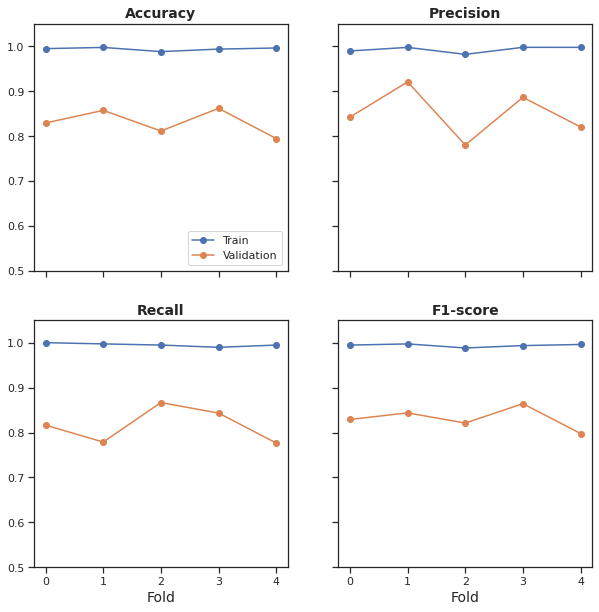

In [155]:
number_folds = list(range(5))

# Build figure
fig, axes = plt.subplots(2,2,figsize = (10, 10), sharey=True, sharex=True)
  
axes[0][0].plot(number_folds, [item[0] for item in train_metrics], 'o-', linewidth=1.5, markersize=6)
axes[0][0].plot(number_folds, [item[0] for item in val_metrics], 'o-', linewidth=1.5, markersize=6)
axes[0][0].set_title('Accuracy', fontsize = 14, fontweight = 'bold');
axes[0][0].legend(['Train', 'Validation'], loc = 'lower right')

axes[0][1].plot(number_folds, [item[1] for item in train_metrics], 'o-', linewidth=1.5, markersize=6)
axes[0][1].plot(number_folds, [item[1] for item in val_metrics], 'o-', linewidth=1.5, markersize=6)
axes[0][1].set_title('Precision', fontsize = 14, fontweight = 'bold');

axes[1][0].plot(number_folds, [item[2] for item in train_metrics], 'o-', linewidth=1.5, markersize=6)
axes[1][0].plot(number_folds, [item[2] for item in val_metrics], 'o-', linewidth=1.5, markersize=6)
axes[1][0].set_title('Recall', fontsize = 14, fontweight = 'bold');
axes[1][0].set_xlabel('Fold', fontsize=14)

axes[1][1].plot(number_folds, [item[3] for item in train_metrics], 'o-', linewidth=1.5, markersize=6)
axes[1][1].plot(number_folds, [item[3] for item in val_metrics], 'o-', linewidth=1.5, markersize=6)
axes[1][1].set_title('F1-score', fontsize = 14, fontweight = 'bold')
axes[1][1].set_xlabel('Fold', fontsize=14)

# Set y axis limits
plt.setp(axes, ylim=[0.5,1.05])

# Save figure
plt.savefig(path + 'Results/figures/cross_validation.png', dpi = 500, transparent = False)

# Show figure
fig.show()